# Can Twitter Be Used To Predict Changes In a Stock value

## 1 An Introduction To The Problem / field
There is of course a lot of interest in tring to find any sort of information that can help to predict the outcome of the stock markets. As there is a lot of money being traded in the stock markets every day, any edge that can be gain in predicting when and in what direction a stock will change can enable large profits.

Due to the large values of such information there has been a lot of research already and continuing to be done in the field however, most of it hasn't be made public due to the arms race between top stock traders.

Company's stocks are valued based on how much the company is currently worth and how much the company is expected to grow over the coming months and years.

Therefore if you are able to tell when the population's feelings/confidence in a company's value/grow increases or decreases. Then you would expect the stock market value of the to follow that same trend.

### 1.1 See References For Other Papers In The Field


## 2 What Data Am I Going To Use
I am planing to curate a list of popular companies from the S&P 500 (Standard and Poor'ss?). This list will also contain the Twitter search queries needed to download the tweets from the companies.
I am also going to look at the sentiment and volume of tweets from the public about the companies. 
I will do this by searching for tweets use that hash tags.

### 2.1 The companies I will review are:
 - Tesla
 - Apple
 - Microsoft
 - Amazon
 - Alphabet (Google)
 - Meta (Facebook)
 - Twitter


### 2.2 Stock market
I am going to collect the stock data from the Yahoo finance library, this greatly increases the ease for downloading this data.

#### 2.2.1 Ethical Impact
##### **Collection and distribution of collected data?**
All of this data is already public and easy to review and collect, therefore this project doesn't make it any easier for anyone to get access to this data.

##### **Impact of Findings?**


##### **Is the Data Personally Identifiable?**
Not Applicable

##### **biases in the data?**
I have only selected companies that I know of and they are all technology based companies.
Each of these Companies are known successes as they have been selected from the S&P 500.

Due to this selection process bias I expect these companies will be more linked to Twitter than other companies.

Therefore, this cannot be used a confirmation for other stocks as it isn't representative of all stocks


### 2.3 Twitter
I originally looked at using Twitter's API to collect all the of tweets. However, this was harder to use and it also added a rate limit on the number of tweets that I could collect.
I realised that the limits would be too low for what I was wanting to do. I then found the snscrape library, which offers a much easier experience, with no cap and also allowing to easily expand the scope to other social networks as well if I want.

#### 2.3.1 Ethical Impact
##### **Collection and distribution of collected data?**


##### **Impact of Findings?**
If this project is found to show that tweets can provide signals to the a stocks future performance, then this could encourage further work into these tweets.
I cannot guarantee how others will review this data, but they could end up using it in non ethical ways.
Also due to the amount of money in this area, a lot of money could be put in to extra data collection that might be Personally Identifiable.

##### **Is the Data Personally Identifiable?**
The raw data that is collected is Personally Identifiable.
However, I always review the aggregated values from the tweets, never single tweets.


##### **Biases in the data?**
The public sentiment about the companies are collected from tweets that contain hash tags that I felt were relevant.
There could also be a lot of tweets about the companies that didn't include hashtags. So there is a selection bias to users/tweets that meet this criteria.

As some of the companies I am reviewing are social networks, there is likely far more bias, due to the data only being collected from Twitter.
I would expect Twitter users to be more positive about Twitter and less so about Facebook(Meta).




In [1]:
# Import libraries and modules

#yahoo finance to down load the relevent stock market data
import yfinance as yf

# social network scrape to download the tweets from twitter
import snscrape.modules.twitter as sntwitter

#libraries for cleaning the data
import pandas as pd
import numpy as np

#libraries for file read and writing
import json
import os

#libraries for parsing and converting date time formats
from datetime import datetime
from dateutil import parser

# libraries for analysing the sentiment of the tweets
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SentimentAnalyzer
sentimentAnalyzer = SentimentAnalyzer()

#libraries for plotting data
import matplotlib.pyplot as plt
from matplotlib import style

#to show word cloud to check twitter data
from wordcloud import WordCloud

# Show all matplotlib graphs inline
%matplotlib inline  
# using the style for the plot
plt.style.use('dark_background')
# set plot size
plt.rcParams['figure.figsize'] = [30, 15]


## 3 Limitations To Project Scope
This is is a very large field that can be researched for a lifetime, so I have to limit the scope of the project, and I have a 4 week time limit.

I did experiment with a wider scope, but the extended time needed for computation reduced my ability to iterate.
I wanted to focus on a few companies at a deeper evaluation instead of little to no value of evaluation spread over more stocks.


#### 3.1 Stock Data:
 - I am not going to look at all trades happening in each day - only the open price and volume
 - I am only going to look at the last 10 years of data

#### 3.2 Twitter Data:
 - First of all I will review the tweets that are sent from the company or it's CEO
 - then I will look at all tweets about the company
 - this will be limited to the when the company's hashtags are used in tweets.

Due to these limitation I will not be able to prove there is a link between between tweets and the stock price, to a level that could be used to make confident stock market trades. But This should highlight if there is more time should be spend in this field.

In [2]:
#Scope Limits

# Limit the time range that I am going to review
StartTime = "2012-05-01"
EndTime = "2022-05-01"

# what counts as a jump in values 
MinDaysBetweenJumps = 7

#I am only going to look at changes in stock market piece that follow these rules
StockJumpTriggerRatio = 0.5
StockJumpTriggerPercentage = 1

# twitter's data is more volatile so needs a larger threshold
TwitterJumpTriggerRatio = 1.25
TwitterJumpTriggerPercentage = 7.5

#Where to cache data
TweetCacheFolder_Small = "CachedTweets_Small"
TweetCacheFolder_Large = "CachedTweets_Large"
StockCacheFolder = "CachedStockData"

TweetCacheDict = {}
StockCacheDict = {}

In [3]:
#load the companiesToReview data
# this includes teh company name, stock ticker and details need to get the tweets

with open("config.json", "r") as file:
	companiesToReview = json.load(file)

In [4]:
def StrToDate(date):
	try:
		date = parser.parse(date)
	except:
		raise Exception("invalid date: " + str(date) + " Of type: " + str(type(date)))
	
	
	date = datetime(date.year, date.month, date.day)
	return date

In [5]:
def GetTweetSentiment(text):
	scores = sentimentAnalyzer.polarity_scores(text)
	return scores["compound"]

In [6]:
def GetTweetsFromAboutCompany(companyData, isPublicOpinion=False):

	tweetCacheFolder = TweetCacheFolder_Small
	dictKey = companyData["StockName"]

	if isPublicOpinion: 
		tweetCacheFolder = TweetCacheFolder_Large
		dictKey += "_isPublicOpinion"

	if not os.path.isdir(tweetCacheFolder):
		os.mkdir(tweetCacheFolder)

	cachePath = os.path.join(tweetCacheFolder, "tweets_" + companyData["StockName"] + ".csv")

	#dict cache exists
	if dictKey in TweetCacheDict:
		tweetsDf = TweetCacheDict[dictKey]

	# file cache exists
	else:
		if os.path.exists(cachePath):
			tweetsDf = pd.read_csv(cachePath)
			for i in range(len(df)):
				tweetsDf["Date"][i] = StrToDate(tweetsDf["Date"][i])

			

		else:
			# build the query
			query = "("

			twitterUsernames = companyData["TwitterUsernames"]
			twitterHashTags = companyData["TwitterHashTags"]

			for i in range(len(twitterUsernames)):
				query += "from:" + twitterUsernames[i]
				if i < len(twitterUsernames) - 1:
					query += " OR "

			if isPublicOpinion:
				query += ") OR ("

				for i in range(len(twitterHashTags)):
					query += twitterHashTags[i]
					if i < len(twitterHashTags) - 1:
						query += " OR "

			query += ") since:" + StartTime + " until:" + EndTime + " -filter:links -filter:replies"
			
			# get tweets that match the query
			tweets = []
			for tweet in sntwitter.TwitterSearchScraper(query).get_items():
				sentiment = GetTweetSentiment(tweet.content)
				tweets.append([tweet.date, tweet.user.username, tweet.content, tweet.replyCount, tweet.retweetCount, tweet.likeCount, tweet.quoteCount, tweet.id, sentiment])

			tweetsDf = pd.DataFrame(tweets, columns=['Date', 'User', 'Content', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount', 'TweetID', 'Sentiment'])

			# to save to csv as a cache
			tweetsDf.to_csv(cachePath)

		

		tweetsDf = tweetsDf.sort_values(by=['Date'])
		TweetCacheDict[dictKey] = tweetsDf
	


	return tweetsDf

In [7]:
def LoadStockData(stockTag):

	if not os.path.isdir(StockCacheFolder):
		os.mkdir(StockCacheFolder)

	cachePath = os.path.join(StockCacheFolder, "Stock_" + stockTag + ".csv")

	#dict cache exists
	if stockTag in TweetCacheDict:
		stockDataDf = TweetCacheDict[stockTag]

	# file cache exists
	else:
		if os.path.exists(cachePath):
			stockDataDf = pd.read_csv(cachePath)
			
		else:
			stockDataDf = yf.download(stockTag, start=StartTime, end=EndTime, progress=False)

			#save data to local cache file
			stockDataDf.to_csv(cachePath)


		for i in range(len(stockDataDf)):
			stockDataDf["Date"][i] = StrToDate(stockDataDf["Date"][i])

		stockDataDf = stockDataDf.sort_values(by=['Date'])
		TweetCacheDict[stockTag] = stockDataDf

	
	return stockDataDf

In [8]:
def CreateMovingAverage(dataFrame, columnToAverage, averageLength):

	movingAverage = []
	movingAverageUpperQuantile = []
	movingAverageLowerQuantile = []

	rows = dataFrame.loc[:,columnToAverage]
	for i in range(len(rows)):

		# get window
		if i < averageLength:
			window = [0]
		else:
			window = rows[i - averageLength : i]

		# calculate moving avg
		windowAverage = round(sum(window) / averageLength, 2)
		movingAverage.append(windowAverage)

		# calculate UpperQuantile
		upperQuantile = np.quantile(window, 0.9)
		movingAverageUpperQuantile.append(upperQuantile)

		# calculate LowerQuantile
		lowerQuantile = np.quantile(window, 0.1)
		movingAverageLowerQuantile.append(lowerQuantile)

	dataFrame.insert(len(dataFrame.columns), columnToAverage + "MA_" + str(averageLength), movingAverage, allow_duplicates=True)
	dataFrame.insert(len(dataFrame.columns), columnToAverage + "MA_" + str(averageLength) + "_UpperQuantile", movingAverageUpperQuantile, allow_duplicates=True)
	dataFrame.insert(len(dataFrame.columns), columnToAverage + "MA_" + str(averageLength) + "_LowerQuantile", movingAverageLowerQuantile, allow_duplicates=True)
	return

In [9]:
def DetectValueJumping(dataFrame, column, lastValueColumn, currentValueColumn, jumpTriggerRatio, jumpTriggerPercentage):
	isValueJumping = []

	for i in range(len(dataFrame)):

		# get window
		if i < 45: #skip the first few days as the moving averages take a few days to settle
			isJump = False
		else:
			upperQuantile = dataFrame[column + "MA_7MA_30_UpperQuantile"][i]
			lowerQuantile = dataFrame[column + "MA_7MA_30_LowerQuantile"][i]
			lastValue = dataFrame[lastValueColumn][i]
			currentValue = dataFrame[currentValueColumn][i]

			interQuantileRange = upperQuantile - lowerQuantile
			triggerRange = jumpTriggerRatio * interQuantileRange

			meantRatio = currentValue > upperQuantile + triggerRange or currentValue < lowerQuantile - triggerRange

			meantPercentage = False
			if lastValue != 0:
				meantPercentage = abs(lastValue - currentValue) / lastValue > jumpTriggerPercentage / 100
			
			isJump = meantRatio and meantPercentage

		isValueJumping.append(isJump)

	dataFrame.insert(len(dataFrame.columns), column + "_IsJumping", isValueJumping, allow_duplicates=True)

	return

def CreateStockTrendData(stockData):

	CreateMovingAverage(stockData, "Volume", 3)
	CreateMovingAverage(stockData, "Volume", 7)
	CreateMovingAverage(stockData, "VolumeMA_7", 30)

	CreateMovingAverage(stockData, "Open", 3)
	CreateMovingAverage(stockData, "Open", 7)
	CreateMovingAverage(stockData, "OpenMA_7", 30)

	DetectStockJumps(stockData)

	return

def DetectStockJumps(stockData):

	DetectValueJumping(stockData, "Volume", "VolumeMA_7", "VolumeMA_3",
		StockJumpTriggerRatio, StockJumpTriggerPercentage)
	DetectValueJumping(stockData, "Open", "OpenMA_3", "Open",
		StockJumpTriggerRatio, StockJumpTriggerPercentage)

	
	bothJumped = stockData["Volume_IsJumping"] * stockData["Open_IsJumping"]
	stockData.insert(len(stockData.columns), "Both_IsJumping", bothJumped, allow_duplicates=True)

	eitherJumped = stockData["Volume_IsJumping"] + stockData["Open_IsJumping"]
	stockData.insert(len(stockData.columns), "Either_IsJumping", eitherJumped, allow_duplicates=True)

	return

def DetectTweetJumps(tweetData):
	CreateMovingAverage(tweetData, "avgSentiment", 3)
	CreateMovingAverage(tweetData, "avgSentiment", 7)
	CreateMovingAverage(tweetData, "avgSentiment", 30)
	CreateMovingAverage(tweetData, "avgSentimentMA_7", 30)

	DetectValueJumping(tweetData, "avgSentiment", "avgSentimentMA_7MA_30", "avgSentimentMA_7",
		TwitterJumpTriggerRatio, TwitterJumpTriggerPercentage)

	return


In [10]:
#get the dates that values jump
def GetValueJumpsDates(stockData, jumpColumn):

	dates = []
	daysSinceLastJump = MinDaysBetweenJumps

	for i in range(len(stockData)):
		daysSinceLastJump += 1

		isJump = stockData[jumpColumn][i]

		if isJump and daysSinceLastJump >= MinDaysBetweenJumps:
			dates.append(stockData["Date"][i])
			daysSinceLastJump = 0

	return dates

In [11]:
#down load all needed data to local cache
# then clean up the data
for companyData in companiesToReview:
	GetTweetsFromAboutCompany(companyData)

	tweetData = GetTweetsFromAboutCompany(companyData, isPublicOpinion=True)

	DetectTweetJumps(tweetData)

	companyData["TweetJumpDates"] = GetValueJumpsDates(tweetData, "avgSentiment_IsJumping")
	

	stockData = LoadStockData(companyData["Tag"])
	CreateStockTrendData(stockData)
	companyData["StockJumpDates"] = GetValueJumpsDates(stockData, "Both_IsJumping")



NameError: name 'df' is not defined

## 4 Check the data is valid

Now that the data is all downloaded, we need to check that it looks correct

### 4.1 Checking The Stock Data
I am going to create two plots each of stock: one of the open price over time, and one of the volume over time.
This will also show an overlay of where the predicting jumps in the stock price is happening.



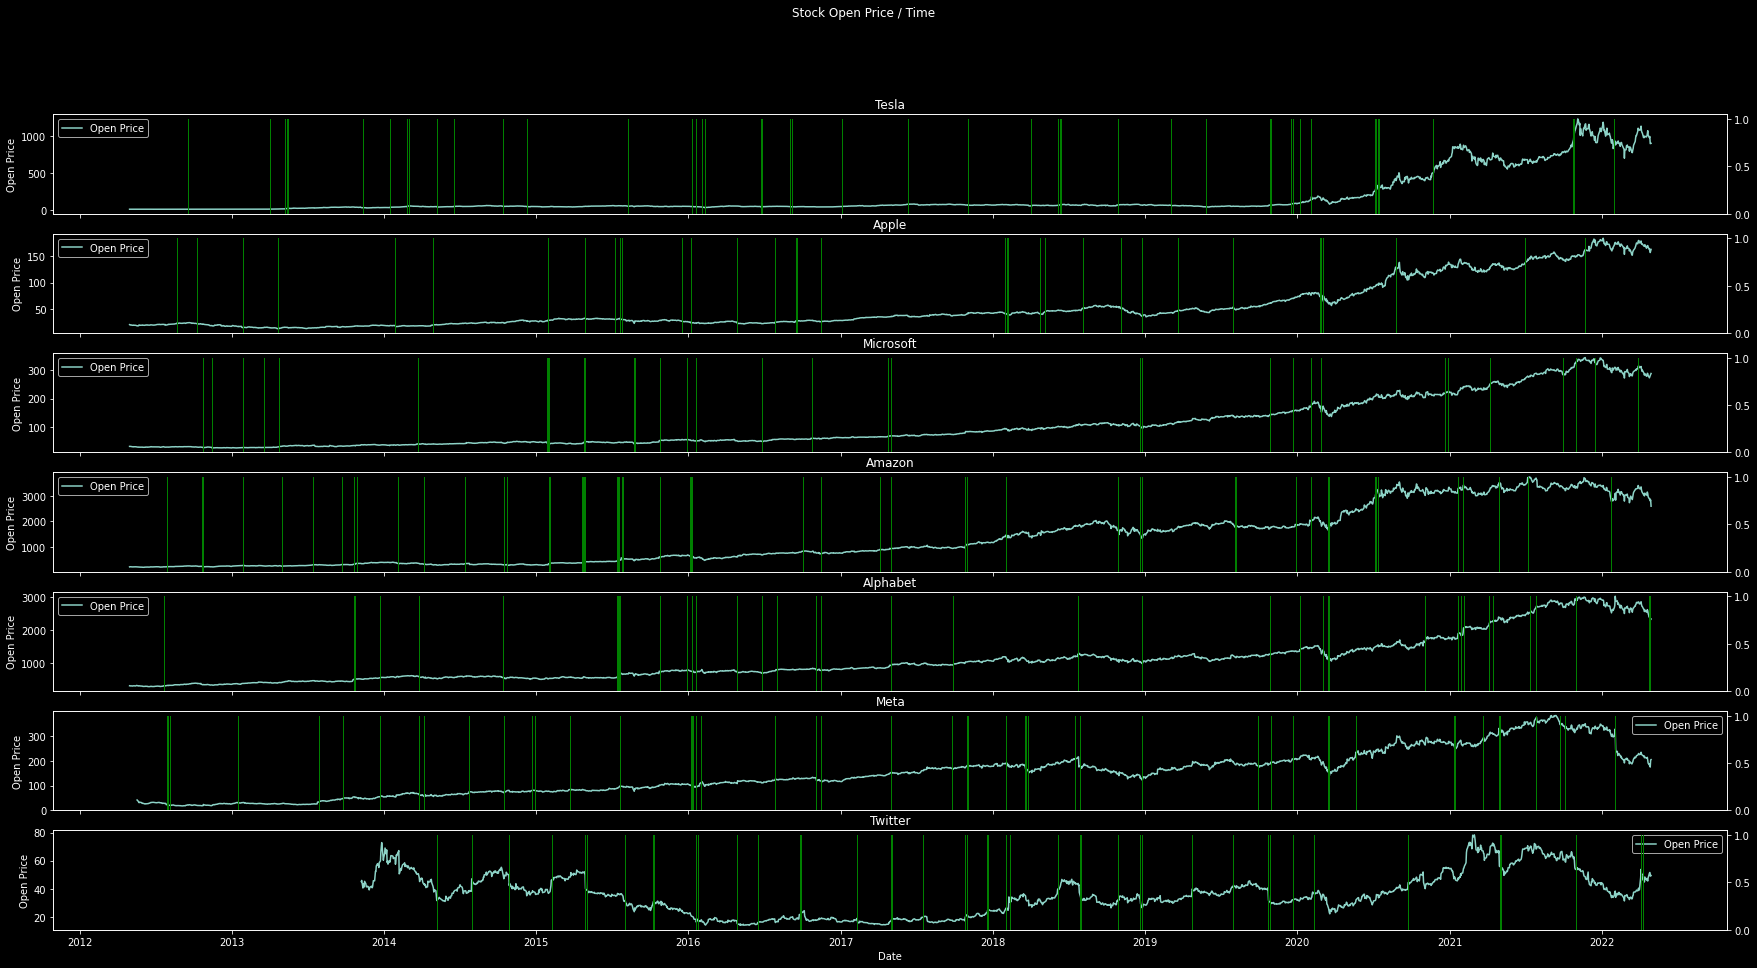

In [ ]:
# plot Stock Open Price / Time

fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Stock Open Price / Time")

for i in range(len(companiesToReview)):
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	axs[i].set_title(companiesToReview[i]["StockName"])
	axs[i].plot(stockData["Date"], stockData["Open"], label = "Open Price")
	
	axs[i].set(xlabel='Date', ylabel='Open Price')
	axs[i].label_outer()
	axs[i].legend()

	ax2 = axs[i].twinx()
	# ax2.bar(stockData["Date"], stockData["Open_IsJumping"], label="open jump")
	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], color=['green'], label="Stock jump")

plt.show()

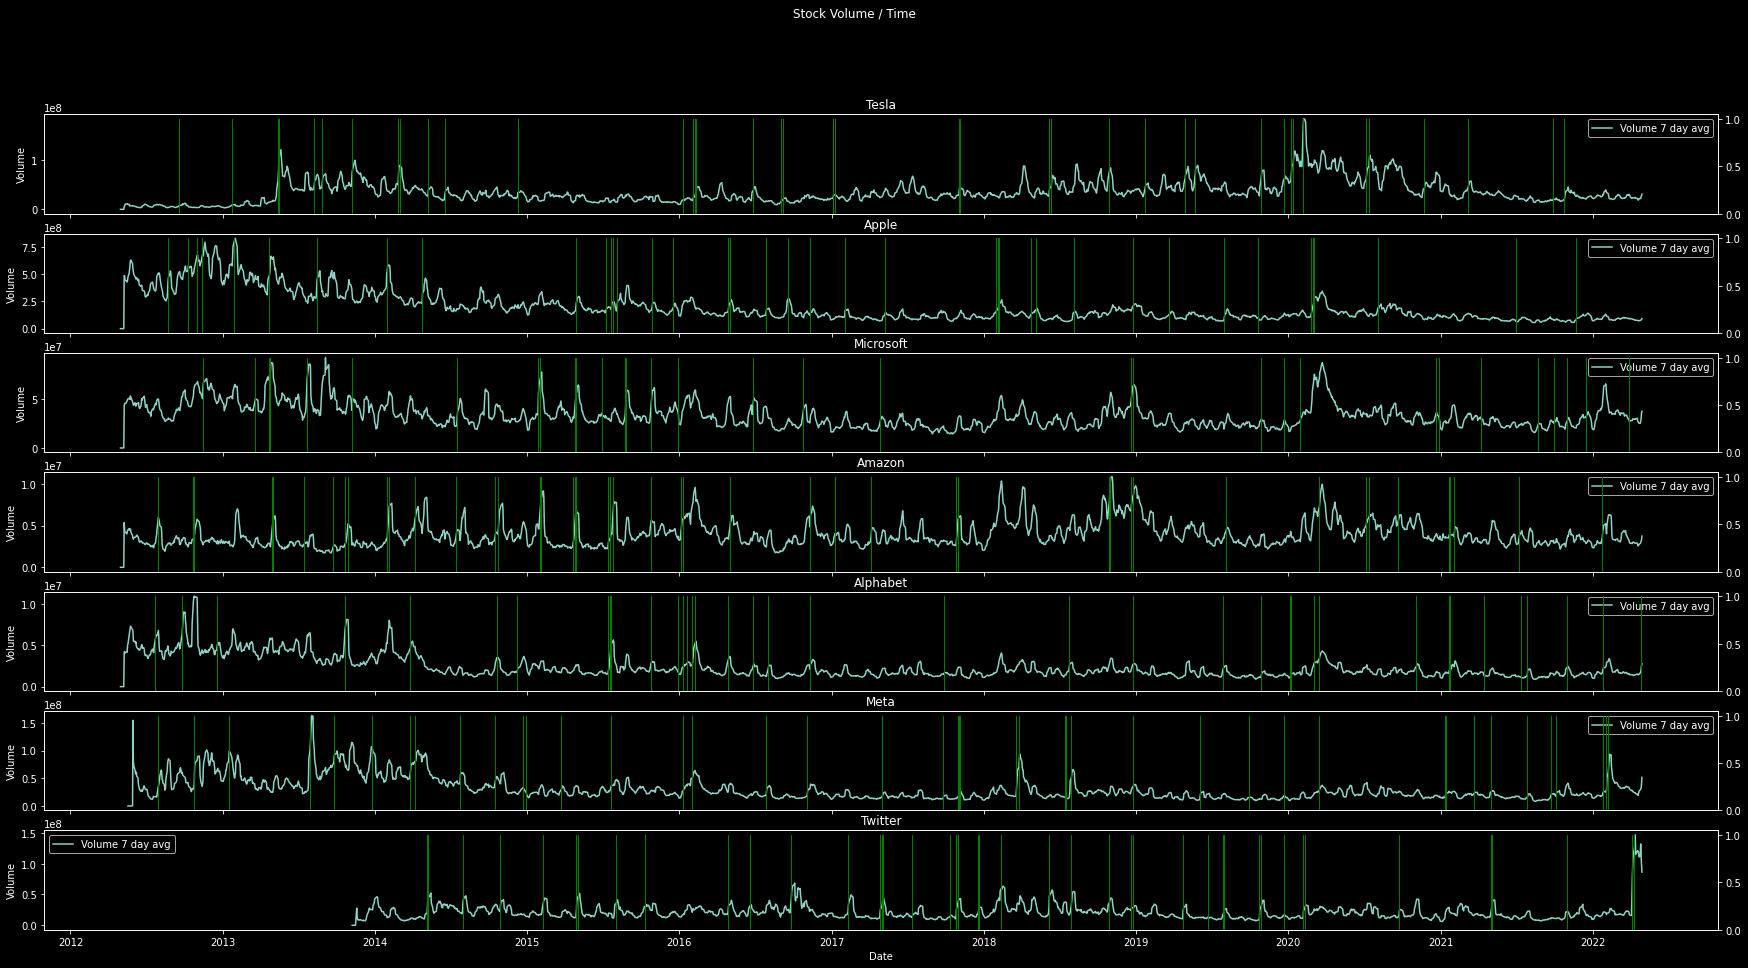

In [ ]:
# plot Stock Volume / Time
fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Stock Volume / Time")

for i in range(len(companiesToReview)):
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	axs[i].set_title(companiesToReview[i]["StockName"])
	axs[i].plot(stockData["Date"], stockData["VolumeMA_7"], label = "Volume 7 day avg")
	
	axs[i].set(xlabel='Date', ylabel='Volume')
	axs[i].label_outer()
	axs[i].legend()

	ax2 = axs[i].twinx()
	
	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], color=['green'], label="Stock jump")


plt.show()

### 4.2 Checking The Twitter Data
I will create a word cloud for each company. This is to check that the tweets collected have the expected words.
I will also plot a graph of volume over time and sentiment.

#### How Sentiment is found
I am using the vader sentiment analyzer (Valence Aware Dictionary and sEntiment Reasoner)
I am using the compound score

"The compound score is computed by summing the valence scores of each word in the lexicon, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers."
quote from vaderSentiment

Tesla
Apple
Microsoft
Amazon
Alphabet
Meta
Twitter


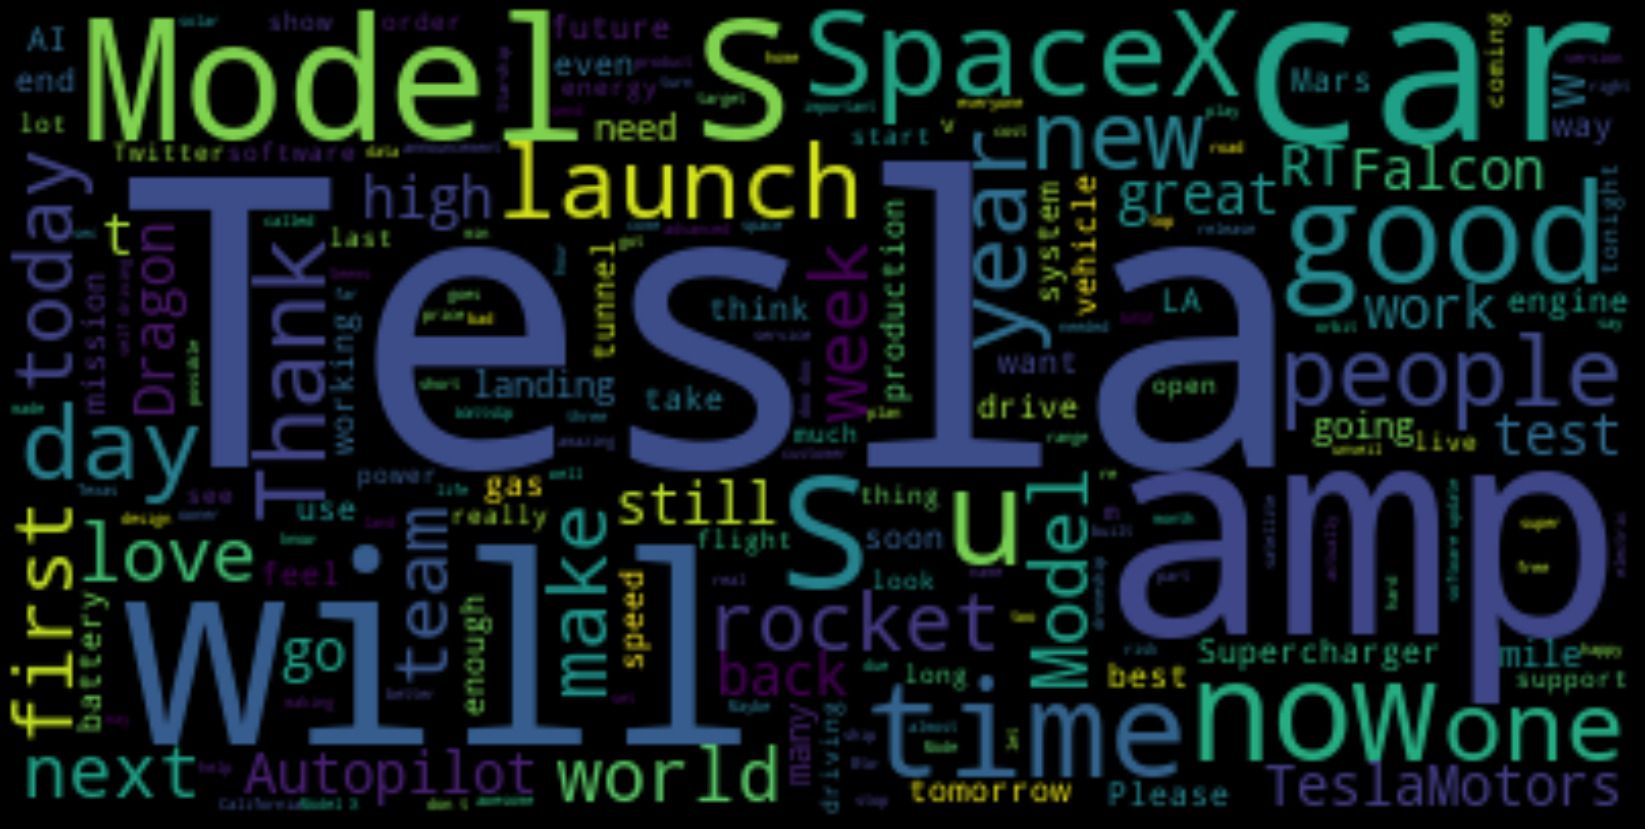

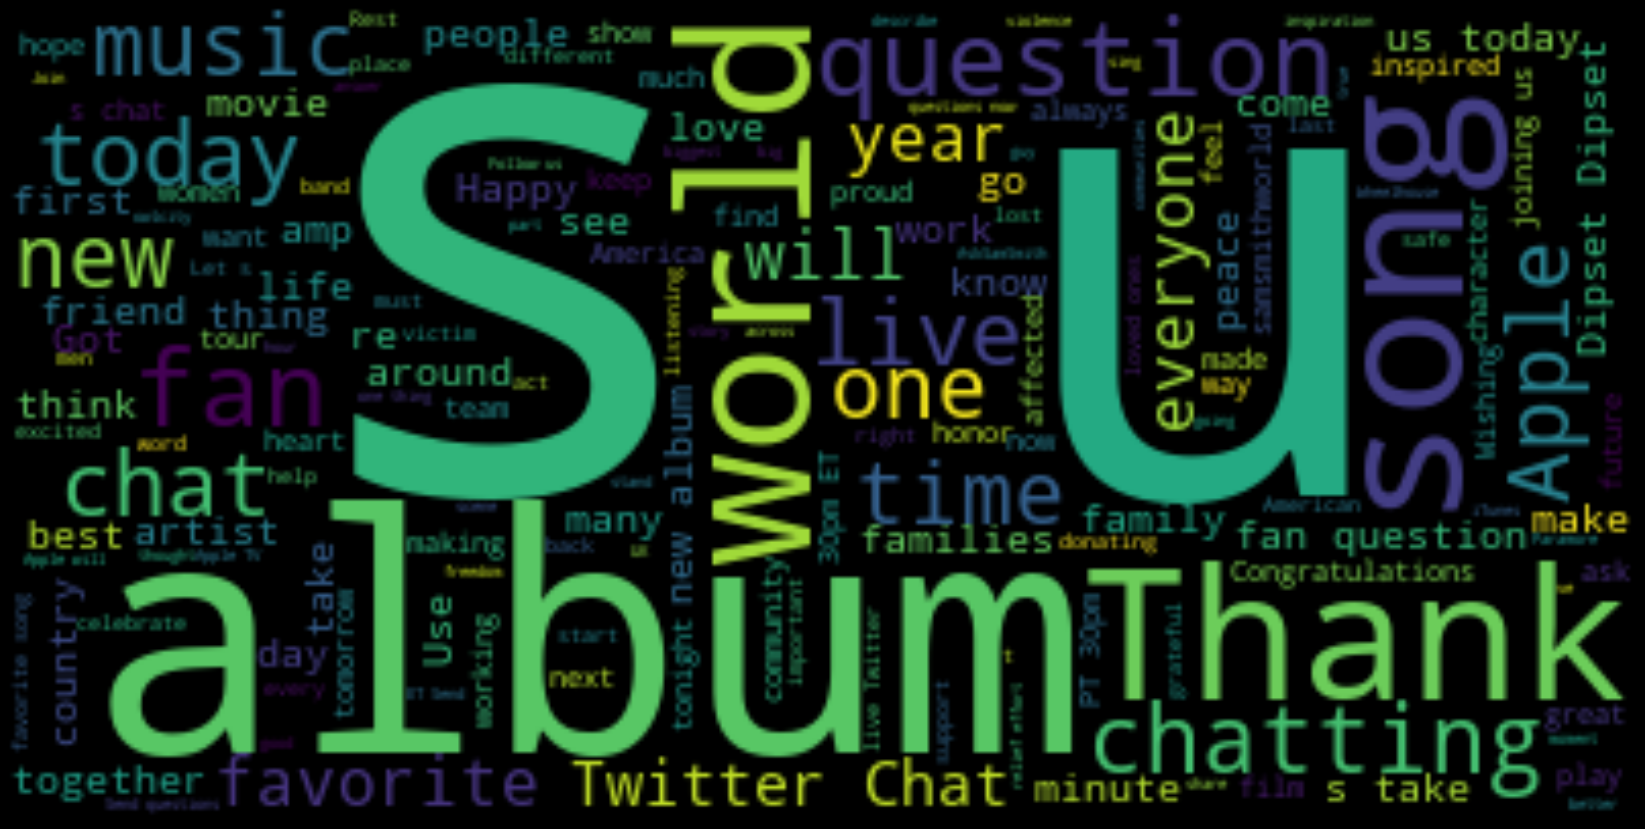

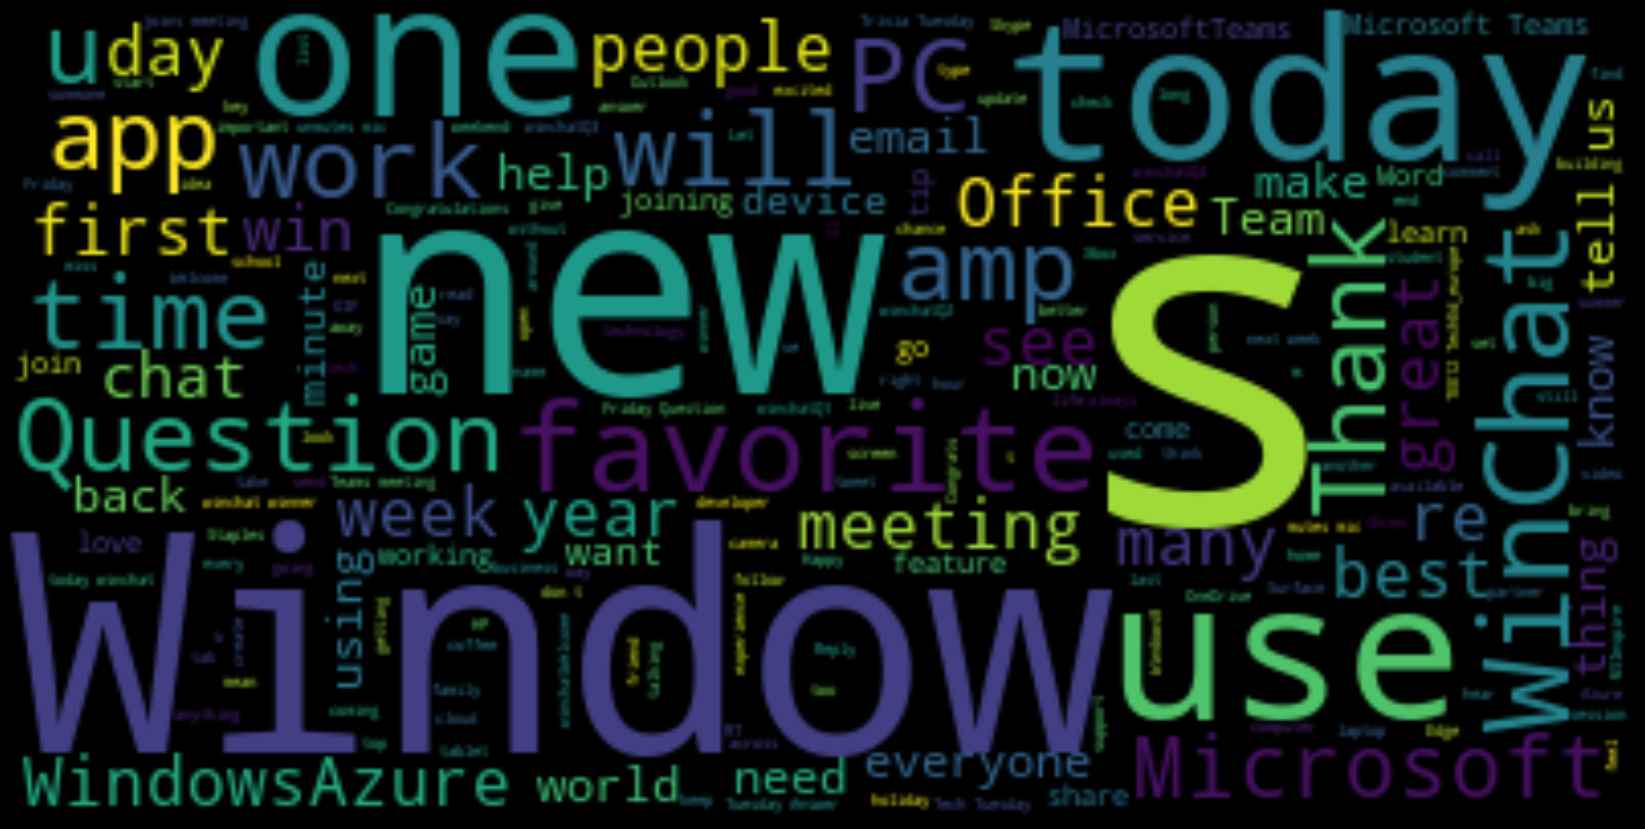

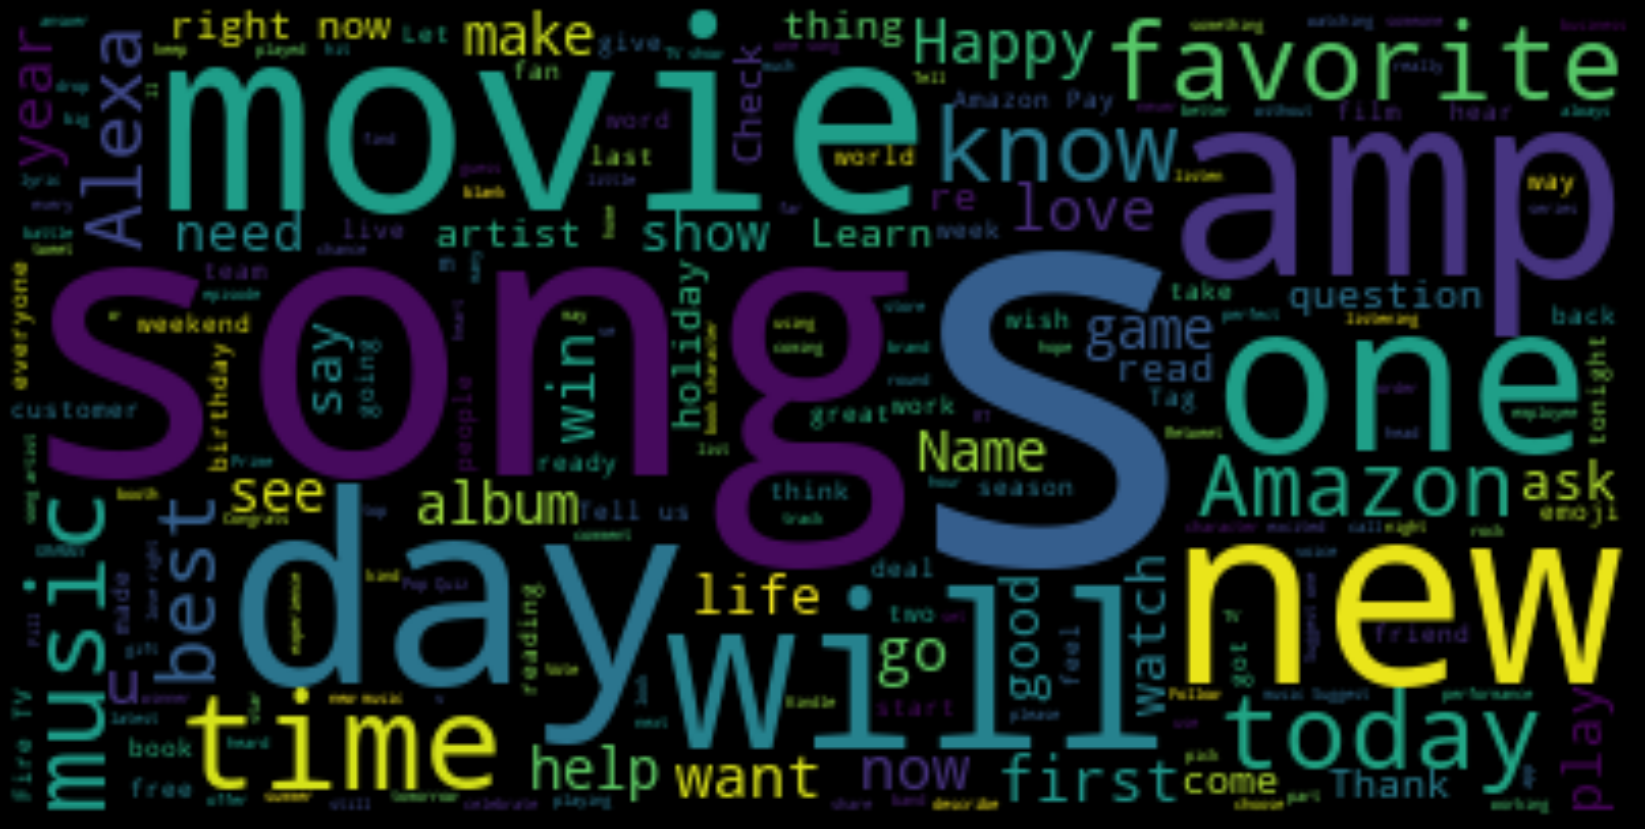

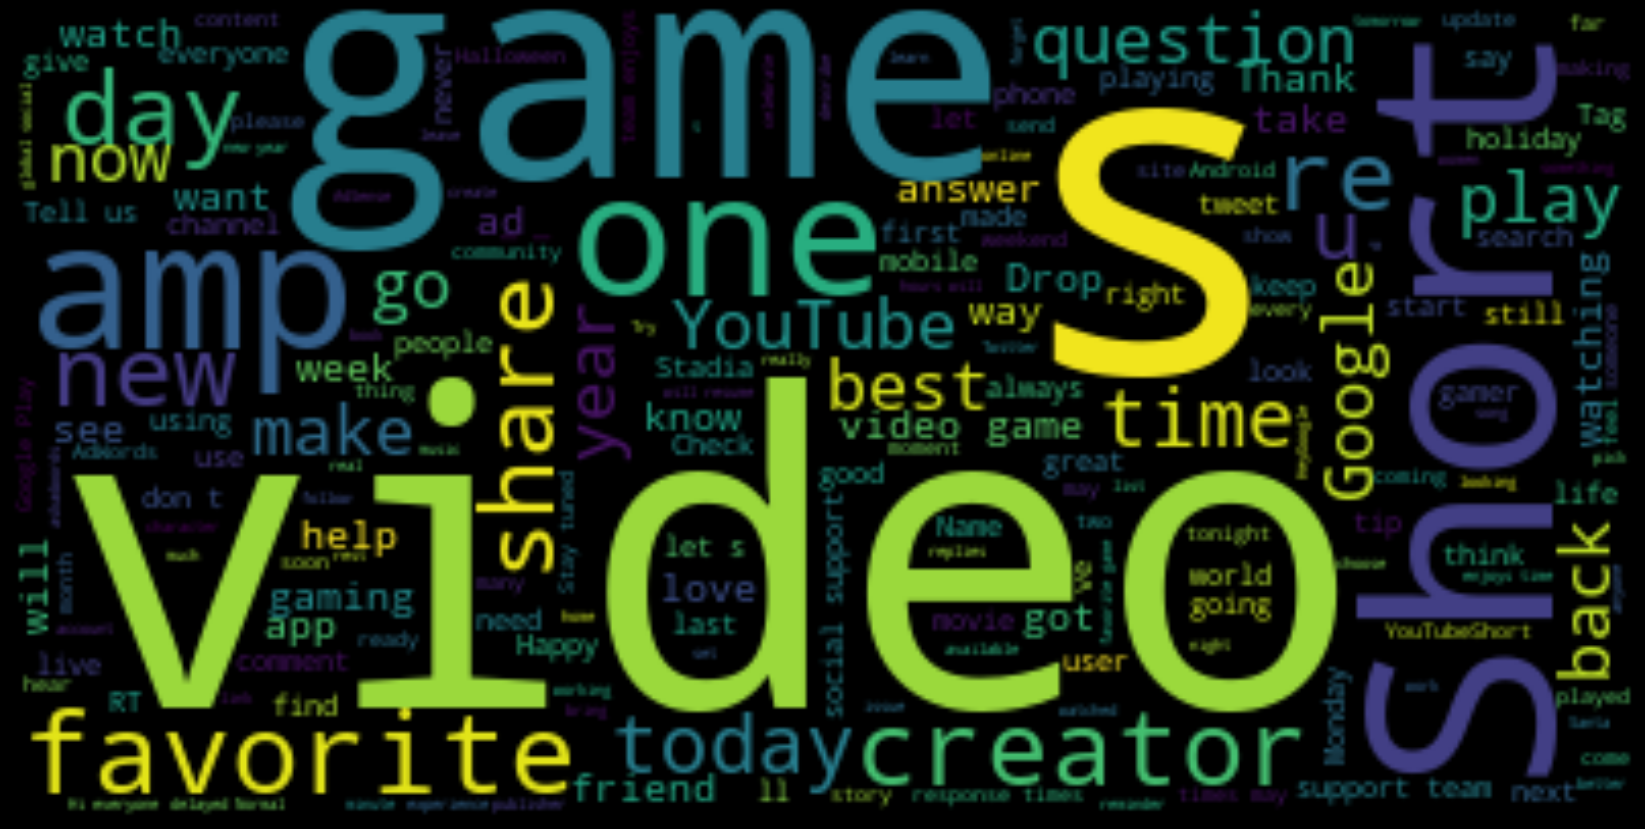

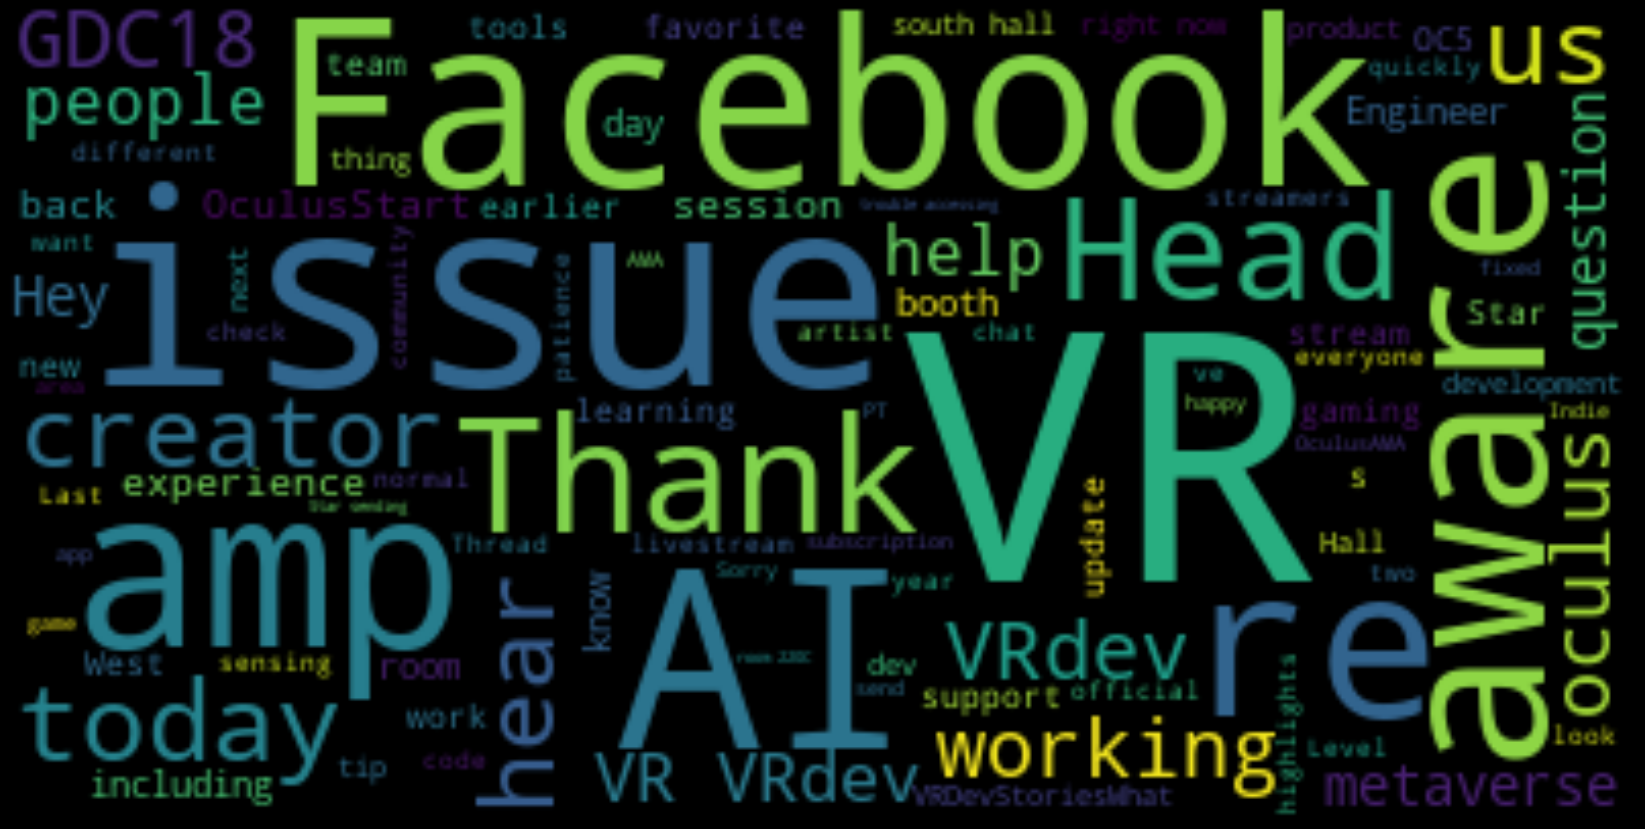

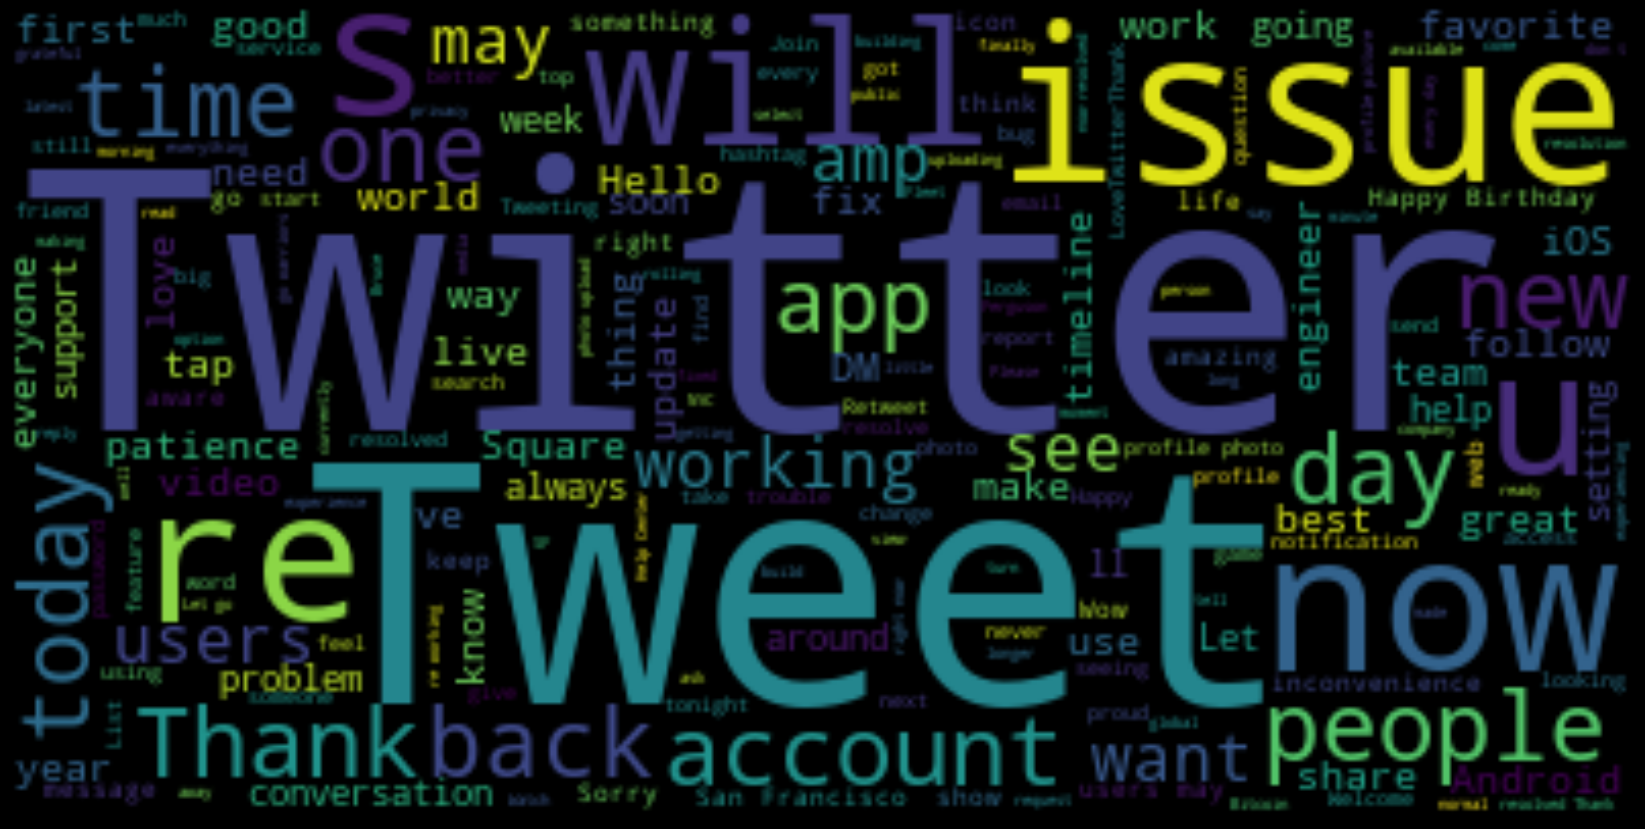

In [ ]:
# create word cloud for each companies' tweets


def BuildTweetText(tweetDf):
	textData = ""
	for i in range(len(tweetDf)):

		textData += tweetDf["Content"][i]

	return textData

for i in range(len(companiesToReview)):
	tweetData = GetTweetsFromAboutCompany(companiesToReview[i], isPublicOpinion=False)
	textData = BuildTweetText(tweetData)

	print(companiesToReview[i]["StockName"])
	wc = WordCloud().generate(textData)
	plt.figure()
	plt.imshow(wc, interpolation='bilinear')
	plt.axis("off")
plt.show()


Each of these Word Clouds are showing the expected words to appear in these companies tweets.

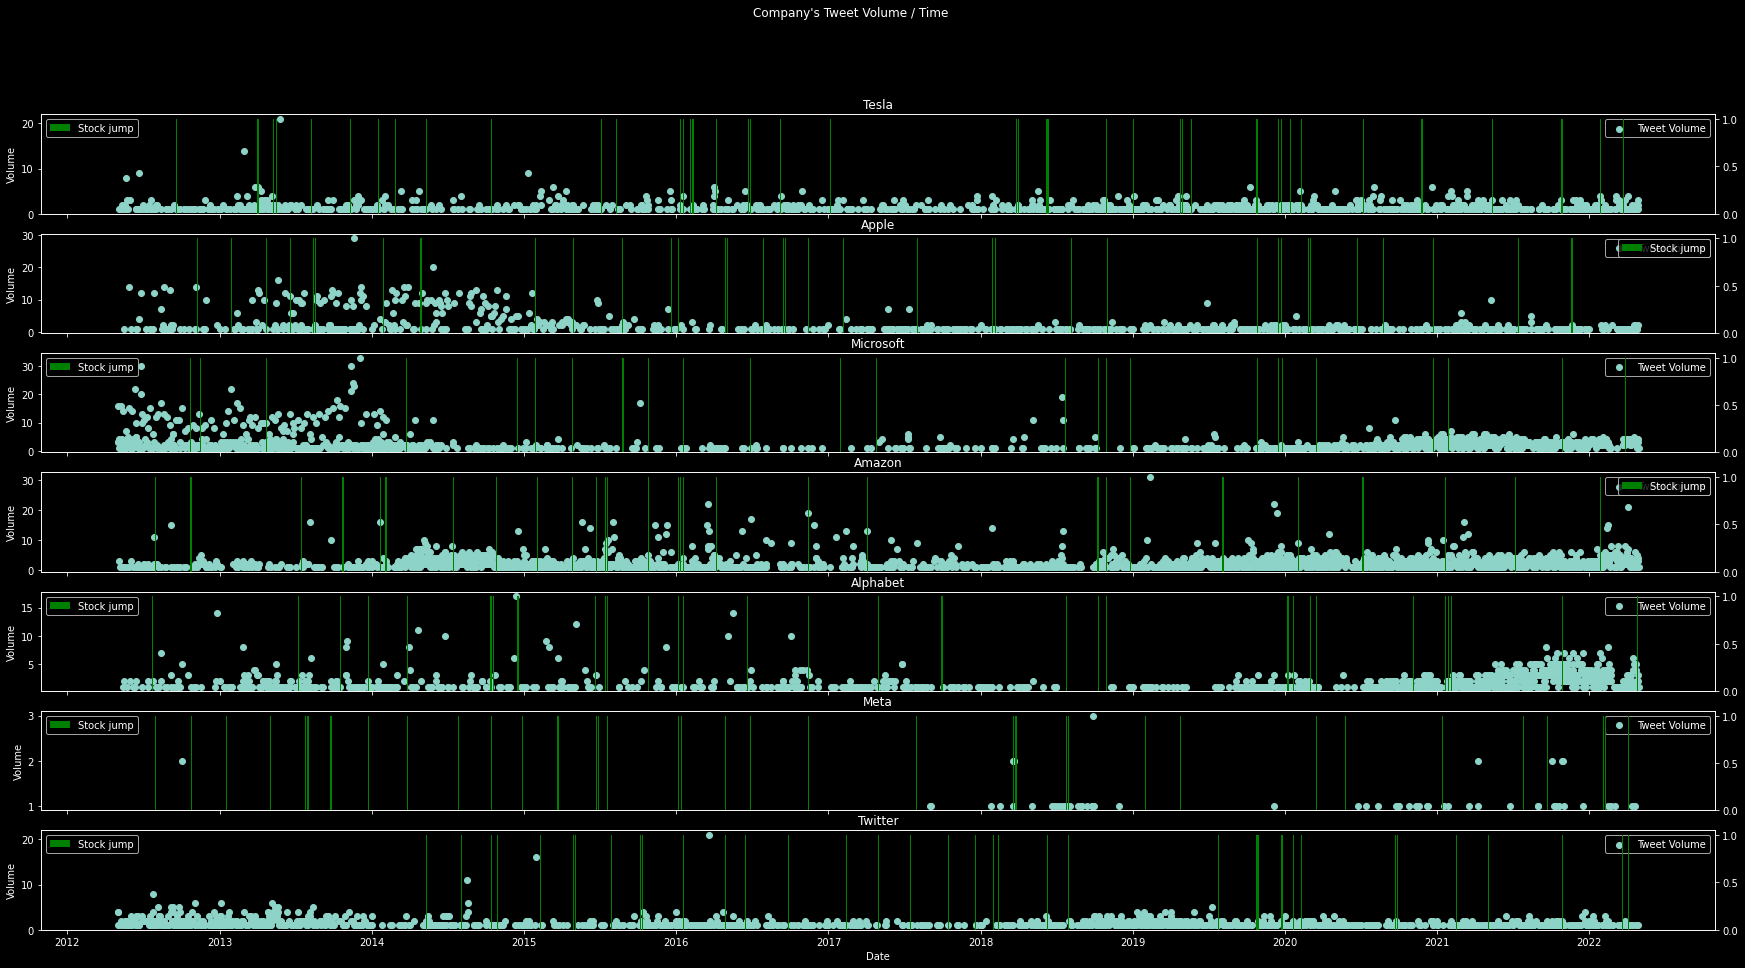

In [ ]:
# Plot Company's Tweet Volume / Time
fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Company's Tweet Volume / Time")

for i in range(len(companiesToReview)):

	tweetData = GetTweetsFromAboutCompany(companiesToReview[i])
	
	grouped = tweetData.groupby(["Date"]).size().reset_index(name='counts')

	axs[i].set_title(companiesToReview[i]["StockName"])
	axs[i].scatter(grouped["Date"], grouped["counts"], label = "Tweet Volume")
	
	axs[i].set(xlabel='Date', ylabel='Volume')
	axs[i].label_outer()
	axs[i].legend()
	
	ax2 = axs[i].twinx()
	
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], color=['green'], label="Stock jump")
	ax2.legend()


plt.show()

This graph is showing some of the bias that comes from picking these companies to review.
As expected, both Facebook(Meta) and Twitter have a very different approach to the tweets that they post, in comparison to the other companies.
It also shows that Facebook is very limited with their tweets. This is expected as Facebook is competing with Twitter.


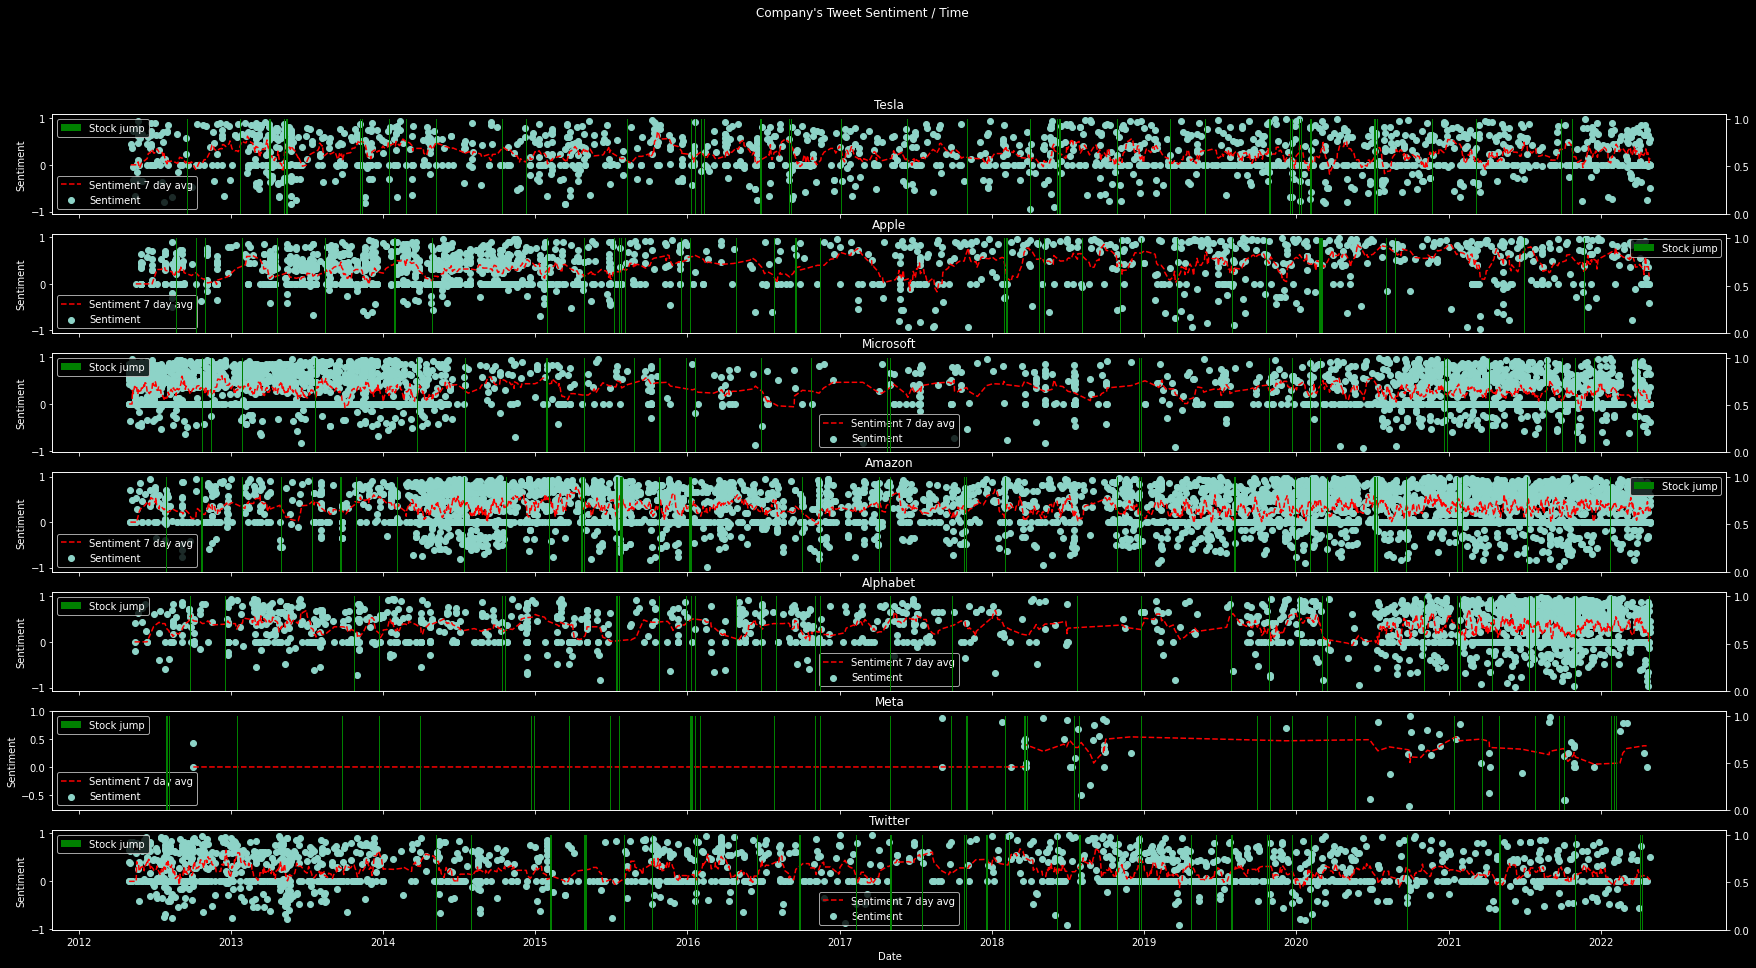

In [ ]:
# plot Company's Tweet Sentiment / Time

fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Company's Tweet Sentiment / Time")

for i in range(len(companiesToReview)):

	tweetData = GetTweetsFromAboutCompany(companiesToReview[i])
	
	axs[i].set_title(companiesToReview[i]["StockName"])

	avgSentiment = tweetData.groupby("Date")['Sentiment'].mean().reset_index(name='Sentiment')
	CreateMovingAverage(avgSentiment, "Sentiment", 7)
	axs[i].plot(avgSentiment["Date"], avgSentiment["SentimentMA_7"], "r--", label = "Sentiment 7 day avg")

	
	axs[i].scatter(tweetData["Date"], tweetData["Sentiment"], label = "Sentiment")
	
	axs[i].set(xlabel='Date', ylabel='Sentiment')
	axs[i].label_outer()
	axs[i].legend()
	
	ax2 = axs[i].twinx()
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], color=['green'], label="Stock jump")

	ax2.legend()


plt.show()

It is interesting to see that most tweets from these companies have a positive sentiment, with a few limited date ranges that are more negative.

But so far there doesn't seem to be any link between tweets from a company and their stock jumping


I am now going to review the tweets from the public instead of from just the companies. My thinking is that stock values are based on the public's opinion of the company. So if the public's views change then so should the stock value.

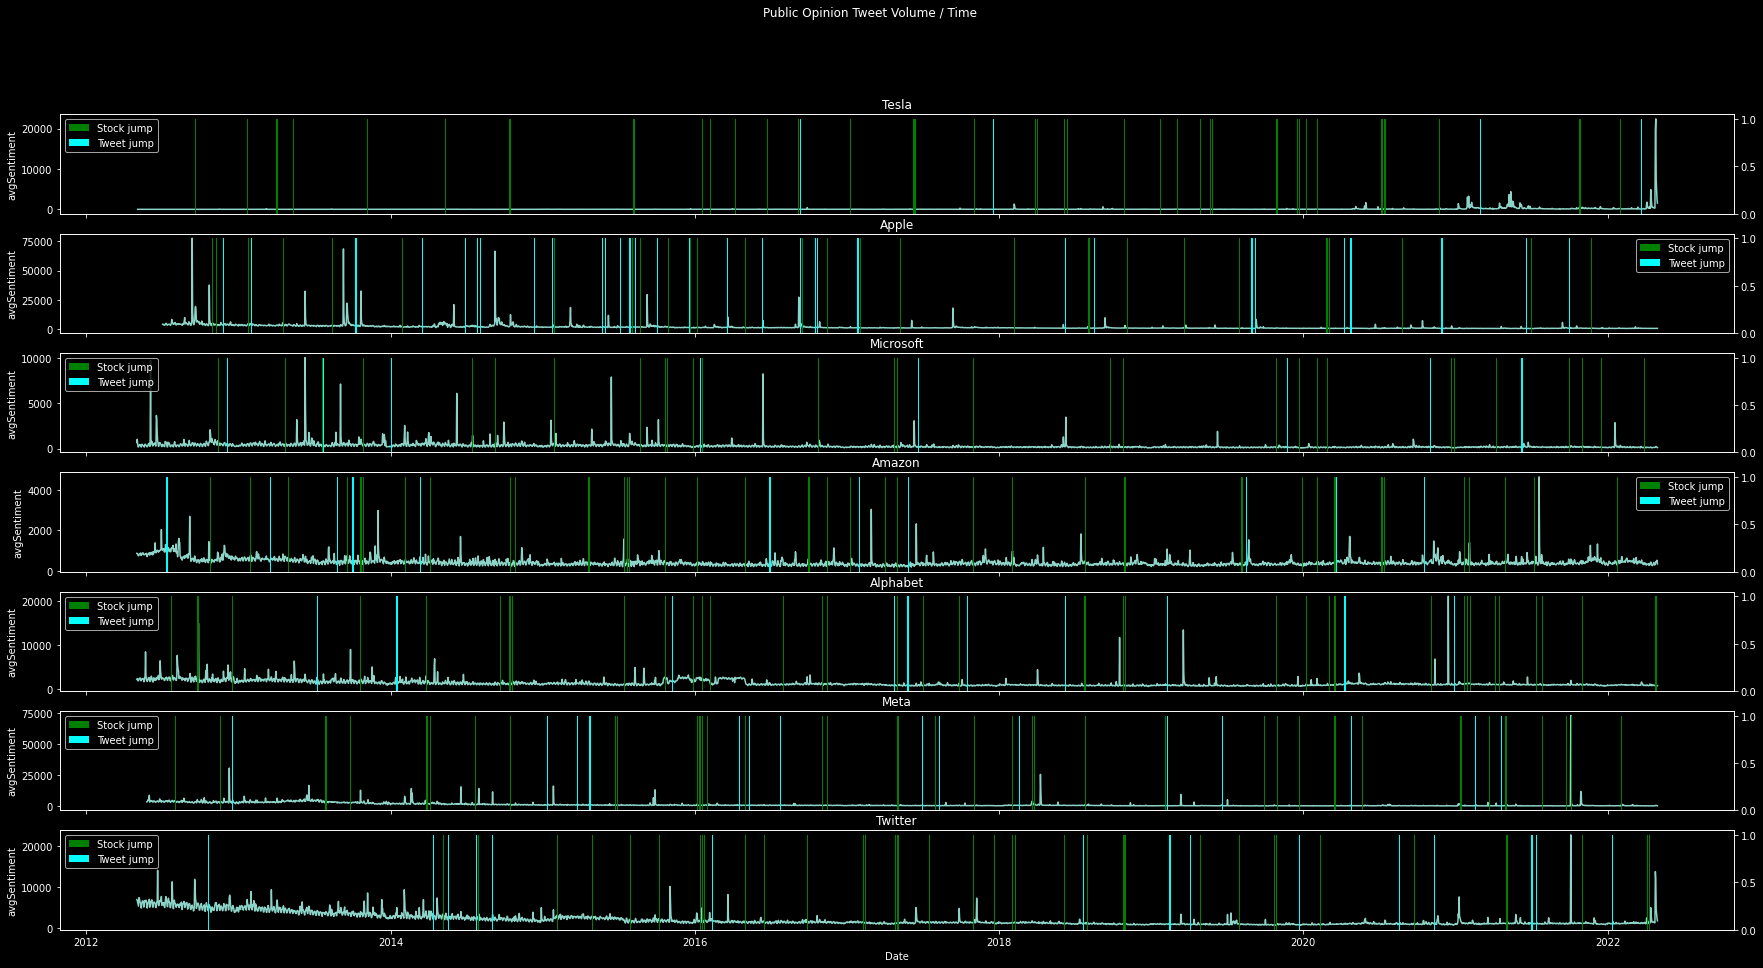

In [ ]:
# plot Public Opinion Tweet Volume / Time

fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Public Opinion Tweet Volume / Time")

for i in range(len(companiesToReview)):

	tweetData = GetTweetsFromAboutCompany(companiesToReview[i], isPublicOpinion=True)
	
	axs[i].set_title(companiesToReview[i]["StockName"])

	axs[i].plot(tweetData["Date"], tweetData["countTweets"])

	axs[i].set(xlabel='Date', ylabel='avgSentiment')
	axs[i].label_outer()
	
	ax2 = axs[i].twinx()
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], color=['green'], label="Stock jump")
	ax2.bar(tweetData["Date"], tweetData["avgSentiment_IsJumping"], color=['cyan'], label="Tweet jump")
	ax2.legend()


plt.show()

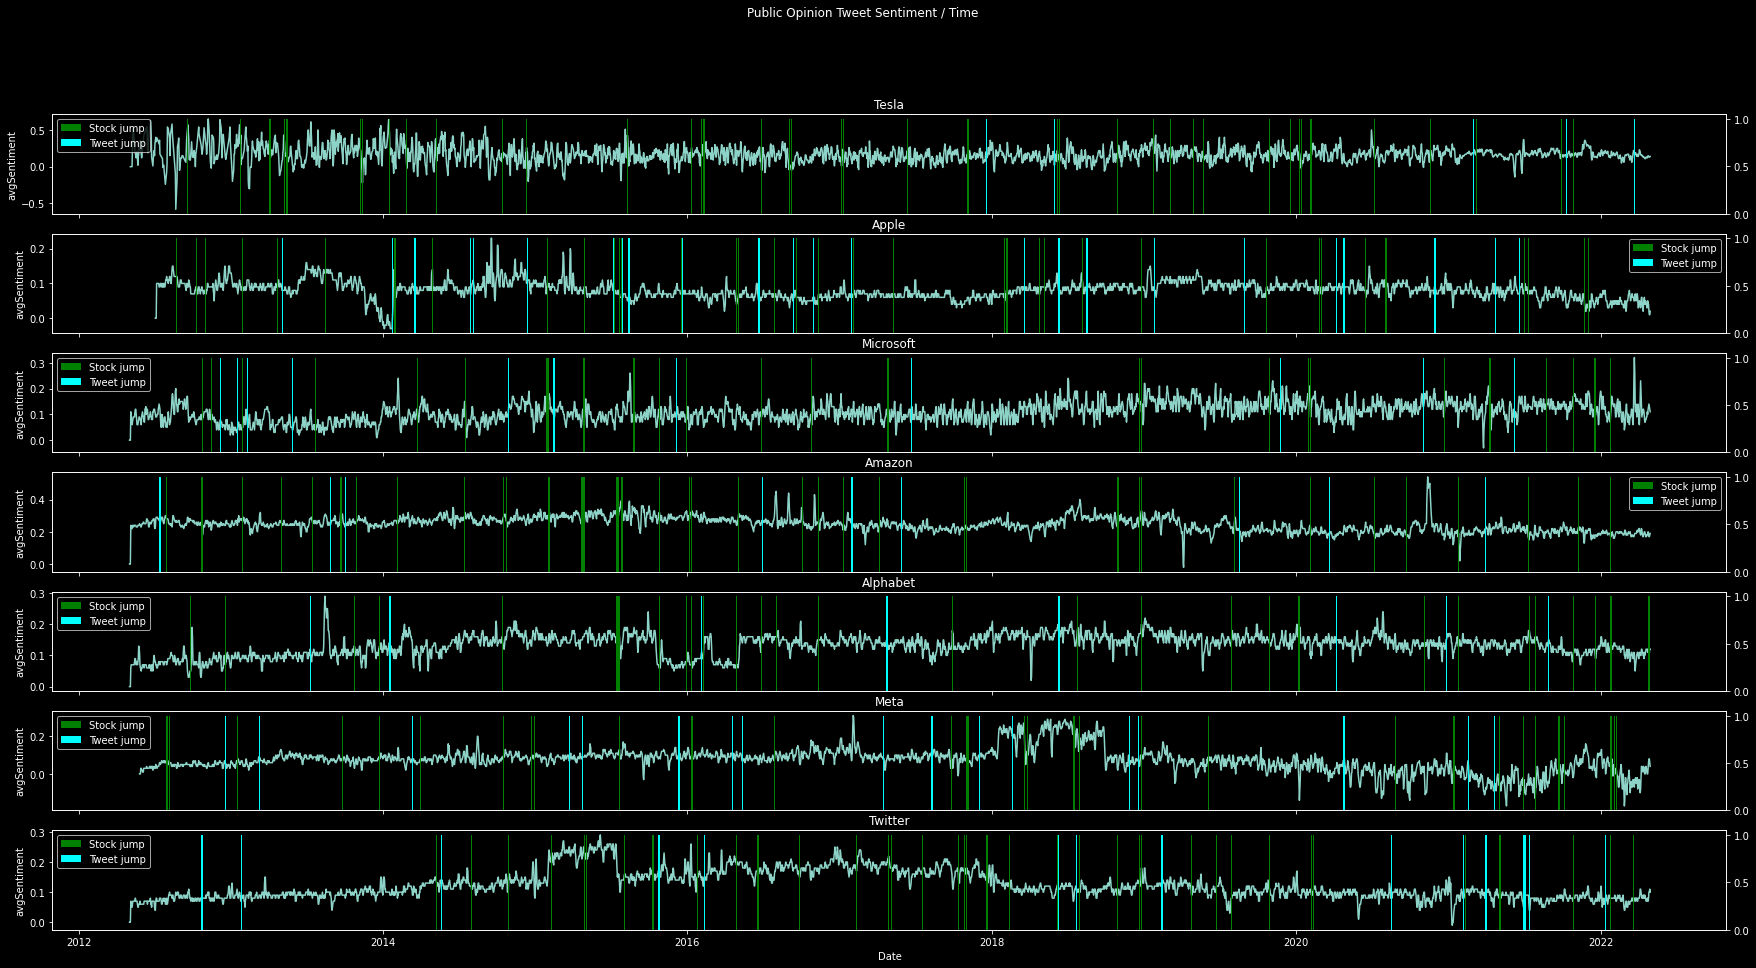

In [ ]:
# plot Public Opinion Tweet Sentiment / Time

fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Public Opinion Tweet Sentiment / Time")

for i in range(len(companiesToReview)):

	tweetData = GetTweetsFromAboutCompany(companiesToReview[i], isPublicOpinion=True)
	
	axs[i].set_title(companiesToReview[i]["StockName"])

	CreateMovingAverage(tweetData, "avgSentiment", 7)

	
	axs[i].plot(tweetData["Date"], tweetData["avgSentimentMA_3"], label = "avgSentiment MA_7")

	axs[i].set(xlabel='Date', ylabel='avgSentiment')
	axs[i].label_outer()
	
	ax2 = axs[i].twinx()
	stockData = LoadStockData(companiesToReview[i]["Tag"])

	ax2.bar(stockData["Date"], stockData["Both_IsJumping"], color=['green'], label="Stock jump")
	ax2.bar(tweetData["Date"], tweetData["avgSentiment_IsJumping"], color=['cyan'], label="Tweet jump")
	ax2.legend()


plt.show()

This graph is starting to show some examples of a link between the stock price and the tweet sentiment.
One example is Alphabet's sentiment just before 2016 dropped by about 1/2, then there was a jump in the stock price

However, I need to do more to prove this as reviewing the data by hand is likely to add a lot of bias 

In [ ]:
def GetDaysBetweenTweetAndStock(tweetDates, stockDates):
	tweetDates = sorted(tweetDates)
	stockDates = sorted(stockDates)

	daysToJumpList = []
	lastStockIndex = 0
	for tweetDate in tweetDates:

		for i in range(lastStockIndex, len(stockDates)):
			
			stockDate = stockDates[i]
			delta = (stockDate - tweetDate).days
			if delta >= 0:
				lastStockIndex = i
				daysToJumpList.append(delta)
				break



	return daysToJumpList

def AvgDaysBetweenJumps(dates):
	dates = sorted(dates)

	deltas = []
	for i in range(len(dates) - 1):
		deltas.append((dates[i+1] - dates[i]).days)
	return sum(deltas) / len(deltas)

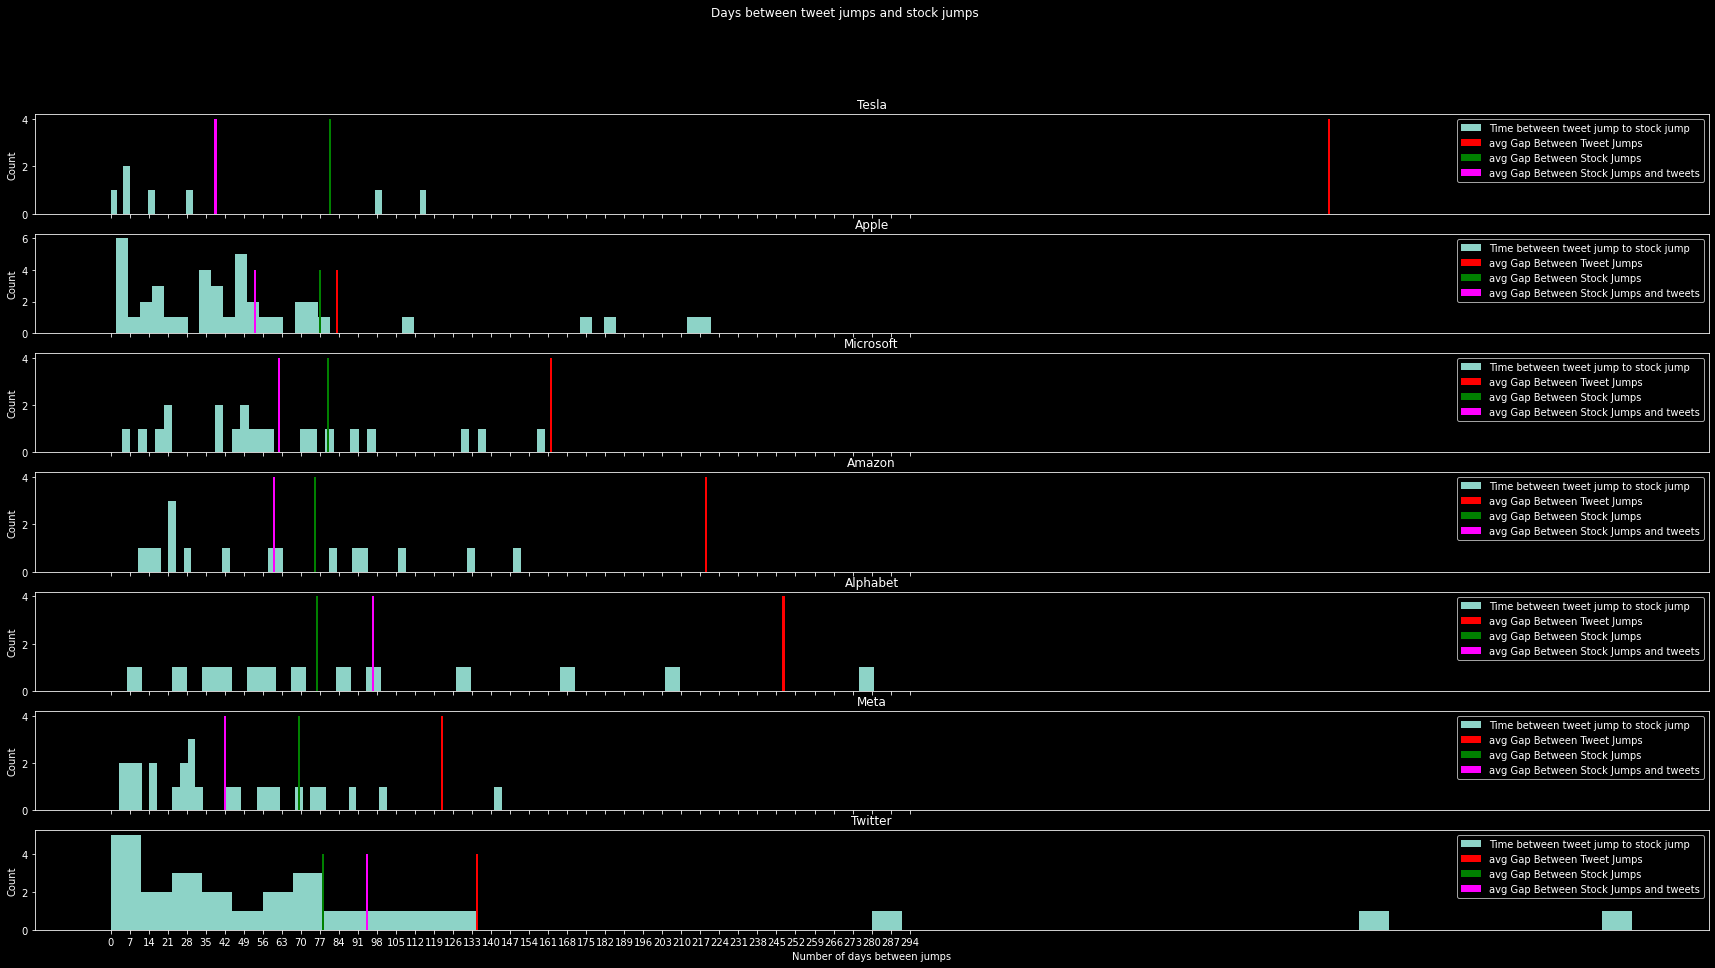

In [ ]:
# get the number of days between each tweeter jump and stock jump

#plot Days between tweet jumps and stock jumps
fig, axs = plt.subplots(len(companiesToReview), sharex=True)
fig.suptitle("Days between tweet jumps and stock jumps")

for i in range(len(companiesToReview)):
	companyData = companiesToReview[i]
	axs[i].set_title(companyData["StockName"])

	tweetJumpDates = companyData["TweetJumpDates"]
	stockJumpDates = companyData["StockJumpDates"]
	daysToJumpList = GetDaysBetweenTweetAndStock(tweetJumpDates, stockJumpDates)

	avgGapBetweenTweetJumps = AvgDaysBetweenJumps(tweetJumpDates)
	avgGapBetweenStockJumps = AvgDaysBetweenJumps(stockJumpDates)
	
	axs[i].hist(daysToJumpList, 50,  label="Time between tweet jump to stock jump ")

	axs[i].bar([avgGapBetweenTweetJumps], [4], color=['red'], label="avg Gap Between Tweet Jumps")
	axs[i].bar([avgGapBetweenStockJumps], [4], color=['green'], label="avg Gap Between Stock Jumps")

	avgGap = sum(daysToJumpList) / len(daysToJumpList)
	axs[i].bar([avgGap], [4], color=['magenta'], label="avg Gap Between Stock Jumps and tweets")


	axs[i].set(xlabel='Number of days between jumps', ylabel='Count')
	axs[i].label_outer()
	axs[i].xaxis.set_ticks(np.arange(0, 300, 7))
	axs[i].legend()

plt.show()

This graph is to help review how well a jump in the tweets could predict the stock price.

## Criteria needed for chance of link 
Criteria that need to be met to show that there could be a link between tweets and stock price.

 - consistent gap between tweet jumps to stock jump
 - the avg gap between stock jumps is greater then the avg gap between tweet jumps to stock jump
 - the avg gap between tweet jumps is larger then gaps between stock jumps


## Conclusion
This Criteria is met for a few stock and is clearly lacking for a few other stocks.

These stocks don't show a likely link:
 - Twitter (surprisingly)
 - Alphabet (google)

Shows there could be some link:
 - Meta(Facebook)
 - Microsoft

Strongest Link:
 - Tesla
 - Apple


### Room for expanded review
I feel this shows there could be some promise in reviewing this more, to see if this link can be strengthen.

#### More companies
This review was Limited to only a few companies due to the computation time and power as well as bandwidth that I have access to.
But this could be extended to far more companies

#### More Social networks
This could also be expanded to review other social network, for example snScrape offers apis for:
 - Facebook
 - Instagram
 - Reddit
 - Twitter

## Reference


### Papers In The Field
 - https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0138441
 - https://arxiv.org/pdf/2105.01402.pdf
 - https://uu.diva-portal.org/smash/get/diva2:1302299/FULLTEXT01.pdf
 - http://cs229.stanford.edu/proj2011/GoelMittal-StockMarketPredictionUsingTwitterSentimentAnalysis.pdf

### Used for validation Of Data
 - https://www.google.com/finance/?hl=en
 - https://Twitter.com/

### Useful Docs
 - https://developer.twitter.com/en/docs/twitter-api
 - https://github.com/JustAnotherArchivist/snscrape
 - https://pypi.org/project/yfinance/
 - https://pandas.pydata.org/docs/reference/frame.html
 - https://matplotlib.org/stable/gallery/index.html
 - https://github.com/cjhutto/vaderSentiment